# 자율주행 보조 시스템 만들기

### import & Kitti Dataset Download
tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용.  
KITTI 데이터셋은 자율주행을 위한 데이터셋임.  
- cvlibs에서 제공하는 [Kitti dataset](http://www.cvlibs.net/datasets/kitti/)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# KITTI 데이터셋 다운로드, 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

#### tfds.show_example   
`tfds.show_example`을 통해 다운로드한 데이터를 확인

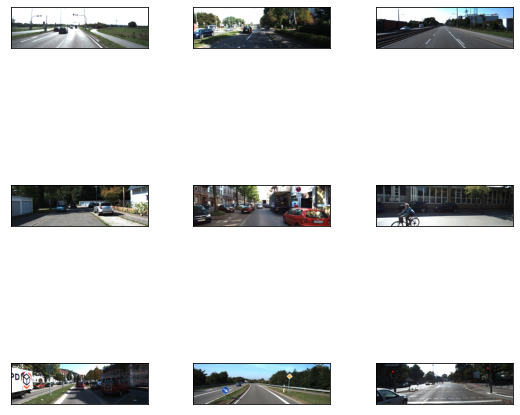

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

#### 데이터 셋의 정보 확인   
7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/ssac12/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

### 데이터 직접 확인하기
`TakeDataset`을 통해 데이터셋을 뽑음  
뽑은 데이터에는 image, label과 같은 정보가 포함되어 있음

In [6]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 2.02,  1.17,  1.76,  1.43,  1.68, -1.63, -1.62], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.00266667, 0.00683575, 0.53573334, 0.33022544],
       [0.00266667, 0.6232045 , 0.46514666, 0.99919486],
       [0.32930666, 0.32613528, 0.5345067 , 0.40726247],
       [0.37250668, 0.54978263, 0.52029335, 0.61419487],
       [0.40573335, 0.38175523, 0.5354933 , 0.4366908 ],
       [0.46130666, 0.525153  , 0.53736   , 0.55117553],
       [0.48546666, 0.51616746, 0.57794666, 0.54144925]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.56, 1.68, 3.69],
       [1.44, 1.64, 4.5 ],
       [1.46, 1.51, 3.24],
       [1.38, 1.59, 4.19],
       [1.38, 1.69, 3.74],
       [1.51, 1.56, 3.81],
       [2.38, 1.98, 5.62]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

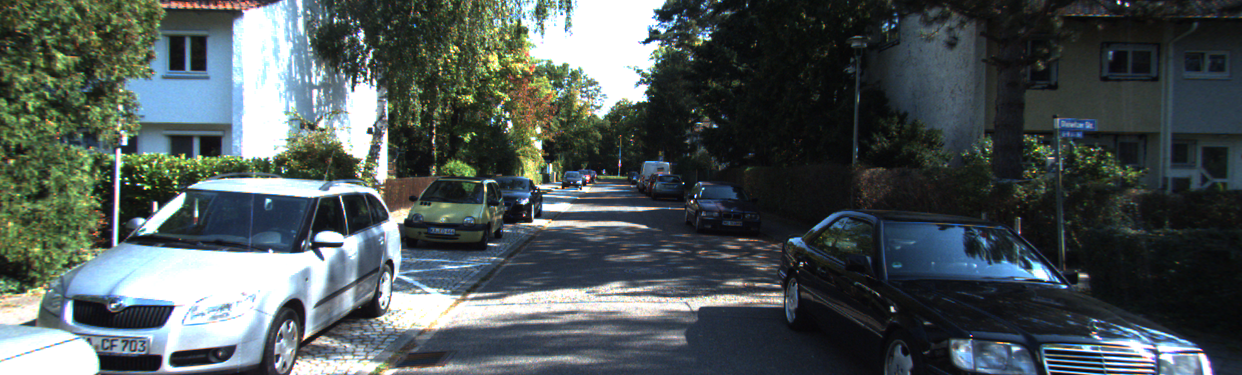

In [7]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

#### 바운딩 박스를 시각화  
이미지의 bbox를 통해 시각화 수행  
Pillow 라이브러리의 [`ImageDraw`](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html) 모듈 사용

width: 1242  height: 375
(7, 4)
[  8.49    374.      410.13998 174.09999]
[ 774.02  374.   1241.    200.57]
[405.06003 251.51001 505.82    174.56   ]
[682.83 235.31 762.83 179.89]
[474.13998 222.84999 542.37    174.19   ]
[652.24    202.01    684.56    173.48999]
[641.08 192.95 672.48 158.27]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F792C1A72D0>


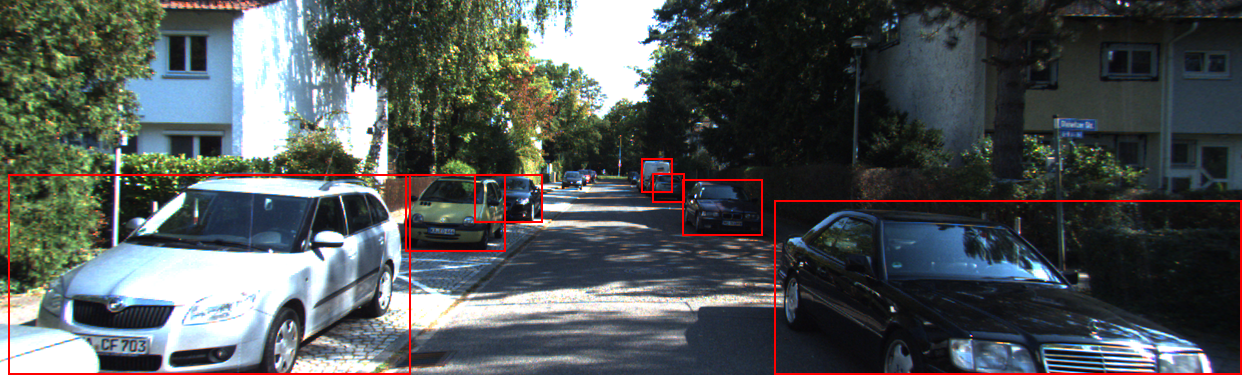

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### RetinaNet


#### 데이터 포맷 변경
tensorflow_dataset의 KITTI데이터셋을 그대로 사용하여 Keras RetinaNet을 학습시키기 위해 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경
- [keras RetinaNet](https://github.com/fizyr/keras-retinanet)

##### 클래스 및 바운딩 박스 정보 추출

In [9]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'


def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)


100%|██████████| 6347/6347 [11:24<00:00,  9.27it/s]


In [10]:
# parse_dataset() 을 적용해서 dataframe을 생성
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:20<00:00,  8.88it/s]


##### 클래스 맵핑

In [11]:
# 클래스 매핑 
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

#### RetinaNet 훈련

In [12]:
# RetinaNet 훈련시작, 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 19:42:19.632339: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 19:42:20.504546: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 19:42:20.526212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 19:42:20.526603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 19:42:20.526625: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 19:42:20.527715: I tensorflow/stream_executor/platform

regression (Concatenate)        (None, None, 4)      0           regression_submodel[0][0]        
                                                                 regression_submodel[1][0]        
                                                                 regression_submodel[2][0]        
                                                                 regression_submodel[3][0]        
                                                                 regression_submodel[4][0]        
__________________________________________________________________________________________________
classification (Concatenate)    (None, None, 2)      0           classification_submodel[0][0]    
                                                                 classification_submodel[1][0]    
                                                                 classification_submodel[2][0]    
                                                                 classification_submodel[3][0]    
          

195/195 [==============================] - ETA: 0s - loss: 1.5087 - regression_loss: 1.1798 - classification_loss: 0.3289
Epoch 00012: saving model to ./snapshots/resnet50_csv_12.h5
195/195 [==============================] - 57s 291ms/step - loss: 1.5087 - regression_loss: 1.1798 - classification_loss: 0.3289
Epoch 13/50
195/195 [==============================] - ETA: 0s - loss: 1.4517 - regression_loss: 1.1355 - classification_loss: 0.3162
Epoch 00013: saving model to ./snapshots/resnet50_csv_13.h5
195/195 [==============================] - 57s 291ms/step - loss: 1.4517 - regression_loss: 1.1355 - classification_loss: 0.3162
Epoch 14/50
195/195 [==============================] - ETA: 0s - loss: 1.5937 - regression_loss: 1.2367 - classification_loss: 0.3570
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
195/195 [==============================] - 57s 291ms/step - loss: 1.5937 - regression_loss: 1.2367 - classification_loss: 0.3570
Epoch 15/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 1.0348 - regression_loss: 0.7883 - classification_loss: 0.2465
Epoch 00028: saving model to ./snapshots/resnet50_csv_28.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
195/195 [==============================] - 57s 291ms/step - loss: 1.0348 - regression_loss: 0.7883 - classification_loss: 0.2465
Epoch 29/50
195/195 [==============================] - ETA: 0s - loss: 1.1168 - regression_loss: 0.8282 - classification_loss: 0.2886
Epoch 00029: saving model to ./snapshots/resnet50_csv_29.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.1168 - regression_loss: 0.8282 - classification_loss: 0.2886
Epoch 30/50
195/195 [==============================] - ETA: 0s - loss: 1.0668 - regression_loss: 0.8152 - classification_loss: 0.2516
Epoch 00030: saving model to ./snapshots/resnet50_csv_30.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
195/195 [=

195/195 [==============================] - ETA: 0s - loss: 1.1170 - regression_loss: 0.8454 - classification_loss: 0.2716
Epoch 00044: saving model to ./snapshots/resnet50_csv_44.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.1170 - regression_loss: 0.8454 - classification_loss: 0.2716
Epoch 45/50
195/195 [==============================] - ETA: 0s - loss: 1.1022 - regression_loss: 0.8397 - classification_loss: 0.2625
Epoch 00045: saving model to ./snapshots/resnet50_csv_45.h5

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
195/195 [==============================] - 57s 291ms/step - loss: 1.1022 - regression_loss: 0.8397 - classification_loss: 0.2625
Epoch 46/50
195/195 [==============================] - ETA: 0s - loss: 1.0899 - regression_loss: 0.8300 - classification_loss: 0.2599
Epoch 00046: saving model to ./snapshots/resnet50_csv_46.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.0899 - regression_loss:

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 20:30:26.584401: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 20:30:28.367502: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 20:30:28.394903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 20:30:28.395310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 20:30:28.395332: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 20:30:28.398536: I tensorflow/stream_executor/platform

#### 시각화

In [14]:
# 변환한 모델을 load하고 추론 및 시각화
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


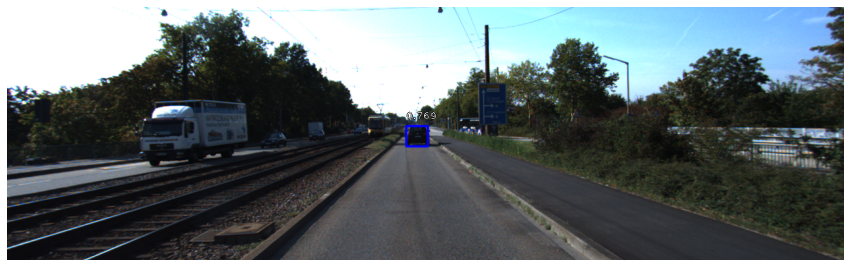

In [15]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

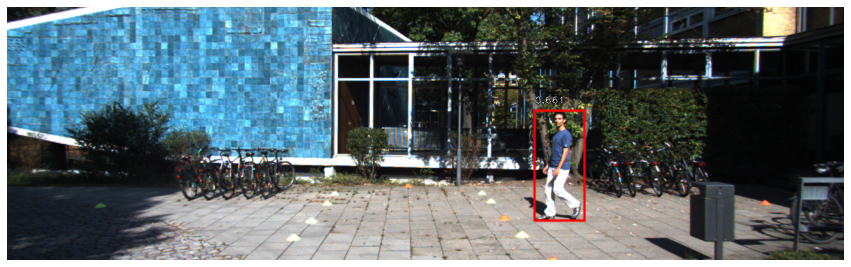

In [16]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

### 자율주행 시스템 만들기
- 입력으로 이미지 경로를 받음
- 정지 조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환  
1. 사람이 한 명 이상 있는 경우
2. 차량의 크기(width or height)가 300px 이상인 경우

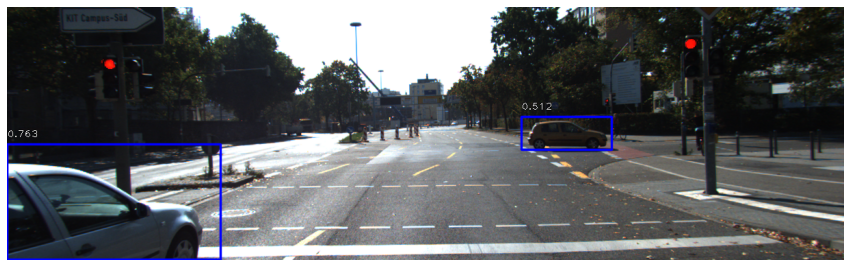

result :  Stop
Stop


In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
# img_path = input()


def self_drive_assist(img_path, size_limit=300):
        result = "Go"
        image = read_image_bgr(img_path)

        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

        color_map = {
            0: (0, 0, 255), # blue
            1: (255, 0, 0) # red
        }

        # preprocess image for network
        image = preprocess_image(image)
        image, scale = resize_image(image)

        # process image
        boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

        # correct for image scale
        boxes /= scale

        # display images
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            #print("box :", box)
            #print("label : ", label)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
            
            if label == 1:
                result = "Stop"
            elif (box[2] - box[0] >= size_limit) or (box[3]-box[1] >= size_limit):
                result = "Stop"

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        print("result : ", result)
        return result


print(self_drive_assist(img_path))    

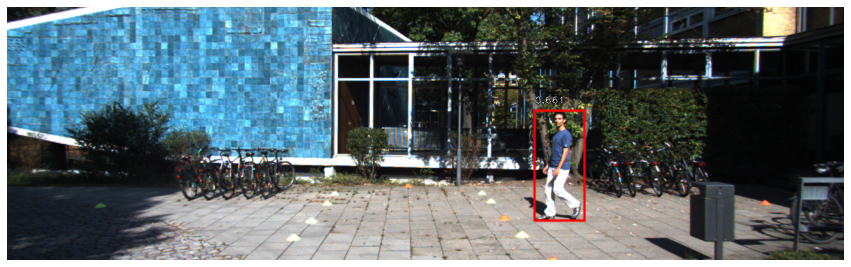

result :  Stop


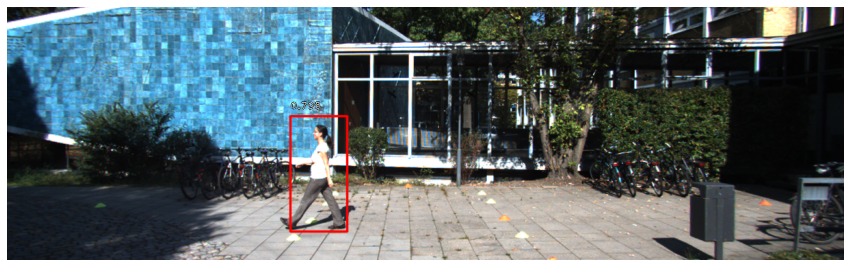

result :  Stop


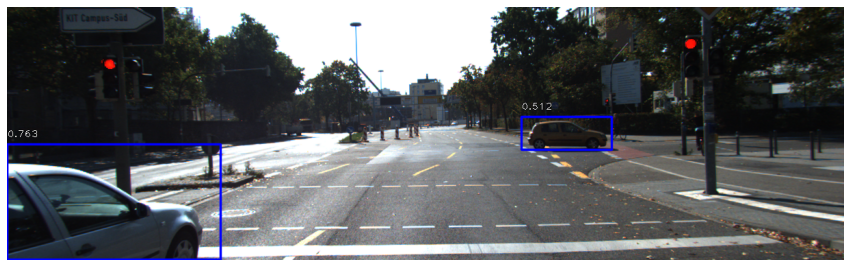

result :  Stop


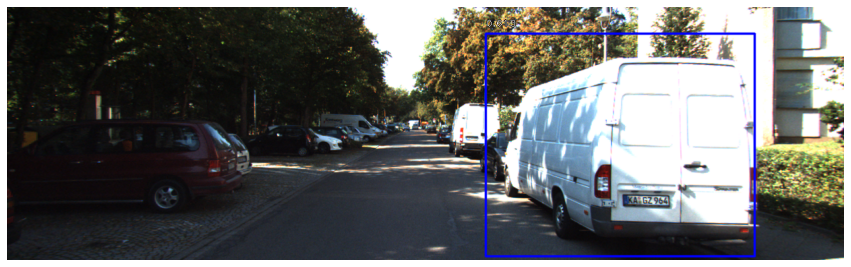

result :  Stop


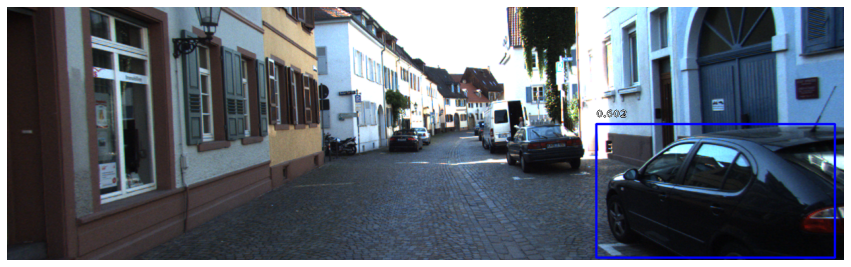

result :  Stop


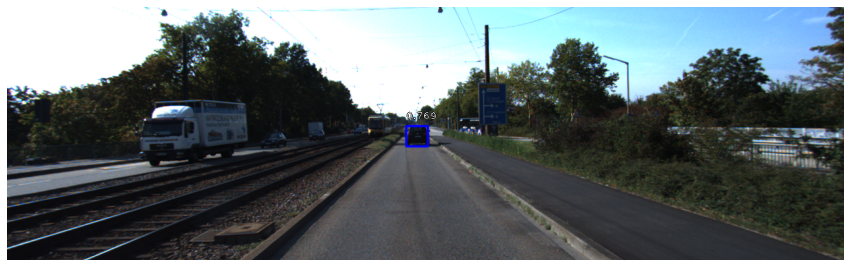

result :  Go


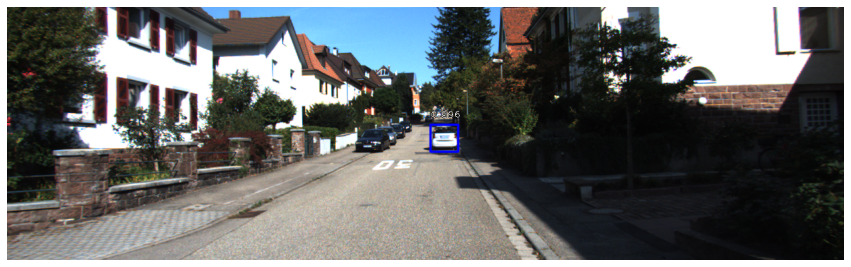

result :  Go


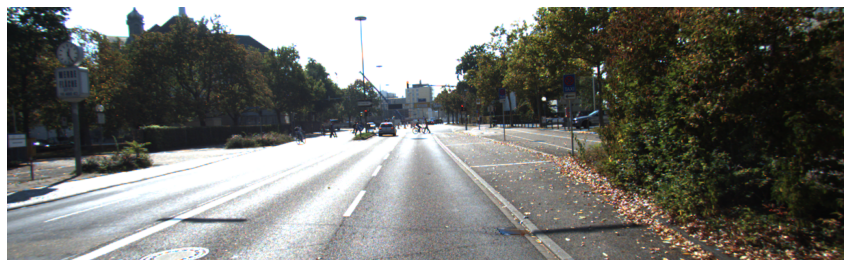

result :  Go


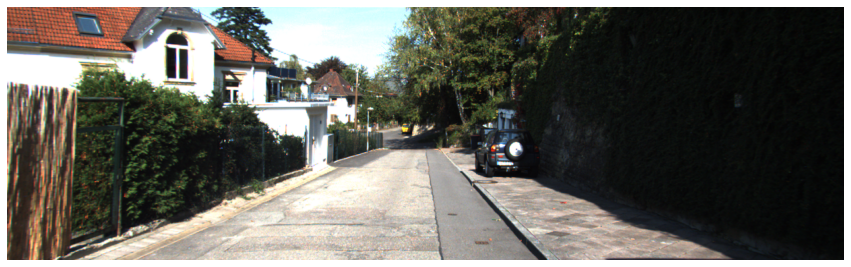

result :  Go


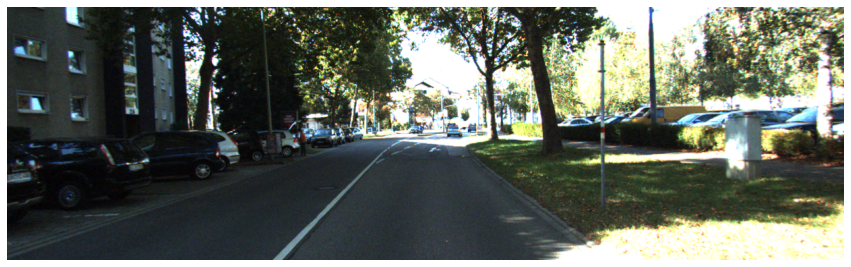

result :  Go
100점입니다.


In [18]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)